# Long Short Term Memory (LSTM) - First trials

### Data Exploration

In [1]:
# Import libraries to use
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math, time, csv
from collections import defaultdict
from math import sqrt

In [2]:
# Load datasets & Analysis
csv_file = './data/TM.csv'
dfTM = pd.read_csv(csv_file, index_col='Date',parse_dates=True)             # Toyota Motor
# dfAP = pd.read_csv('./data/AAPL.csv', index_col='Date',parse_dates=True)  # Apple
# dfGE = pd.read_csv('./data/GE.csv', index_col='Date',parse_dates=True)    # General Electric
# dfMS = pd.read_csv('./data/MSFT.csv', index_col='Date',parse_dates=True)  # Microsoft
# dfSP = pd.read_csv('./data/^GSPC.csv', index_col='Date',parse_dates=True) # S&P 500
dfTM.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-07-24,123.779999,123.779999,122.309998,122.489998,98.390572,418000
2007-07-25,123.389999,123.410004,121.500000,122.290001,98.229897,557900
2007-07-26,122.320000,122.349998,117.050003,119.199997,95.747864,1258500
2007-07-27,121.739998,121.739998,119.040001,120.480003,96.776016,679900
2007-07-30,122.120003,122.599998,121.000000,121.790001,97.828300,639300


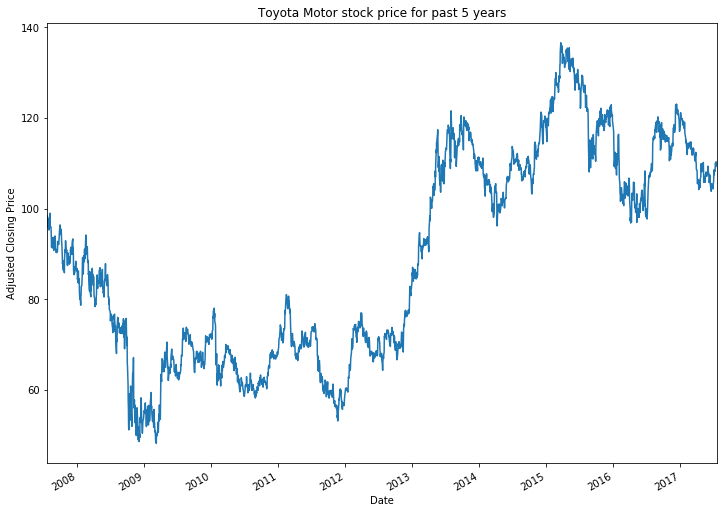

In [3]:
# Plot 'Date'(X-axis) and 'Adj Close'(Y-axis)
adj_close_TM = dfTM['Adj Close']
adj_close_TM = adj_close_TM.plot(figsize=(12, 9), title="Toyota Motor stock price for past 5 years")
adj_close_TM.set_ylabel("Adjusted Closing Price")

plt.show()

## Long Short Term Memory (LSTM) Model

### Import libraries

In [4]:
# Load libraries
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

Using TensorFlow backend.


### Helper functions

In [5]:
# Load only 'Adj Close' column from CSV
def load_adj_close(filePath):
    columns = defaultdict(list) # each value in each column is appended to a list

    with open(filePath) as f:
        reader = csv.DictReader(f)    # read rows into a dictionary format
        for row in reader:            # read a row as {column1: value1, column2: value2,...}
            for (k,v) in row.items(): # go over each column name and value 
                columns[k].append(v)  # append the value into the appropriate list based on column name k

    return columns['Adj Close']

# Loading datasets and turn them into training and testing sets
def load_data_split_train_test(data, seq_len, normalise_window):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

# Normalize function
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

### LSTM Model variables

In [6]:
# LSTM Model
batch_size = 1
nb_epoch = 1
seq_len = 30
loss='mean_squared_error'
optimizer = 'rmsprop'
activation = 'linear'
input_dim = 1
output_dim = 30

### Toyota

/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=30, return_sequences=False, input_shape=(None, 1))`
  # This is added back by InteractiveShellApp.init_path()
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


compilation time :  0.0639958381653
Train on 2126 samples, validate on 112 samples
Epoch 1/1
2126/2126 [==============================] - 251s - loss: 7.6053e-04 - val_loss: 3.2812e-04
Mean squared error (MSE) 0.000143752868767
Root Mean squared error (RMSE) 0.0119896984435


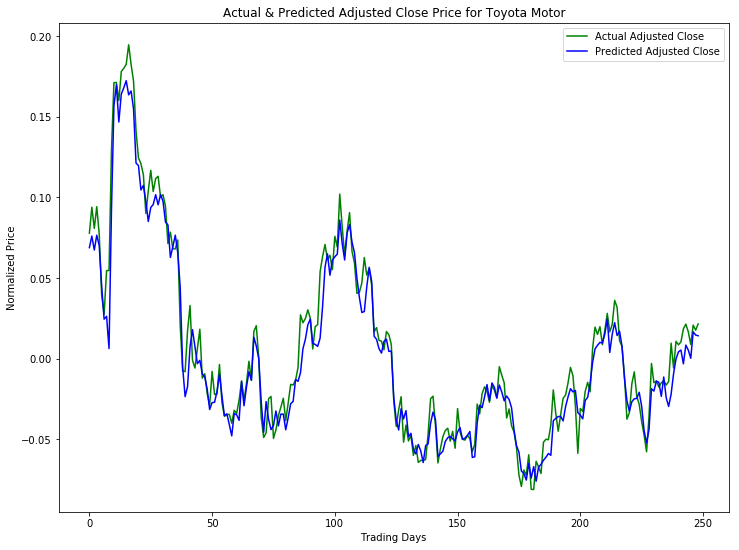

In [7]:
# Get Adjusted Close price and split the data
adj_closes = load_adj_close(csv_file)
X_train_, y_train_, X_test_, y_test_ = load_data_split_train_test(adj_closes, seq_len, True)

# Build Model
model = Sequential()

model.add(LSTM(
    input_dim=input_dim,
    output_dim=output_dim,
    return_sequences=False))

model.add(Dense(
    output_dim=1))
model.add(Activation(activation))

start = time.time()
model.compile(loss=loss, optimizer=optimizer)
print 'compilation time : ', time.time() - start

#Train the model
model.fit(
    X_train_,
    y_train_,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_split=0.05)

testPredict = model.predict(X_test_, batch_size=batch_size)
score = model.evaluate(X_test_, y_test_, batch_size=batch_size, verbose=0)

TM_MSE = score
TM_RMSE = math.sqrt(score)
print 'Mean squared error (MSE)', TM_MSE
print 'Root Mean squared error (RMSE)', TM_RMSE

# Set up plot
plt.rcParams['figure.figsize'] = (12, 9)

fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test_,'g', label='Actual Adjusted Close')
plt.plot(testPredict, 'b', label='Predicted Adjusted Close')

# Set title
ax.set_title('Actual & Predicted Adjusted Close Price for Toyota Motor')
ax.legend(loc='upper right')

plt.show()

### Apple

/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=30, return_sequences=False, input_shape=(None, 1))`
  
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


compilation time :  0.0493550300598
Train on 2126 samples, validate on 112 samples
Epoch 1/1
2126/2126 [==============================] - 231s - loss: 9.1676e-04 - val_loss: 5.4934e-04
Mean squared error (MSE) 0.000206062711005
Root Mean squared error (RMSE) 0.0143548845695


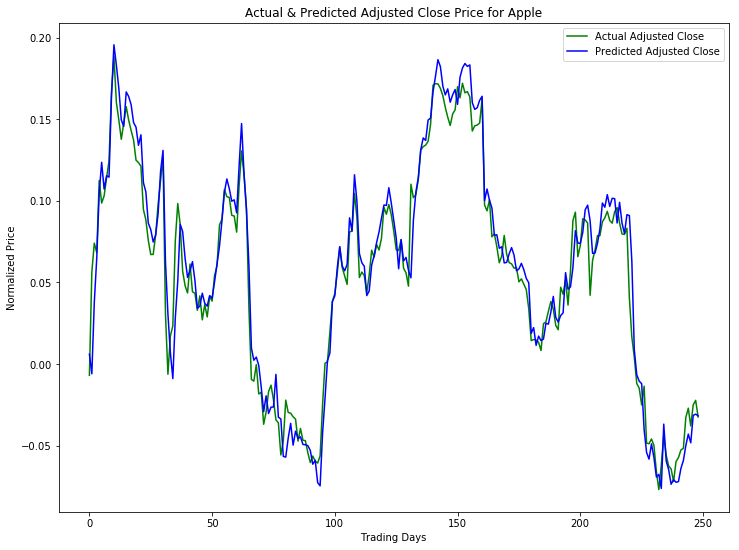

In [8]:
# Load datasets
csv_file = './data/AAPL.csv'

# Get Adjusted Close price and split the data
adj_closes = load_adj_close(csv_file)
X_train_, y_train_, X_test_, y_test_ = load_data_split_train_test(adj_closes, seq_len, True)

# Build Model
model = Sequential()

model.add(LSTM(
    input_dim=input_dim,
    output_dim=output_dim,
    return_sequences=False))

model.add(Dense(
    output_dim=1))
model.add(Activation(activation))

start = time.time()
model.compile(loss=loss, optimizer=optimizer)
print 'compilation time : ', time.time() - start

#Train the model
model.fit(
    X_train_,
    y_train_,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_split=0.05)

testPredict = model.predict(X_test_, batch_size=batch_size)
score = model.evaluate(X_test_, y_test_, batch_size=batch_size, verbose=0)

APPL_MSE = score
APPL_RMSE = math.sqrt(score)
print 'Mean squared error (MSE)', APPL_MSE
print 'Root Mean squared error (RMSE)', APPL_RMSE

# Set up plot
plt.rcParams['figure.figsize'] = (12, 9)

fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test_,'g', label='Actual Adjusted Close')
plt.plot(testPredict, 'b', label='Predicted Adjusted Close')

# Set title
ax.set_title('Actual & Predicted Adjusted Close Price for Apple')
ax.legend(loc='upper right')

plt.show()

### GE

/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=30, return_sequences=False, input_shape=(None, 1))`
  
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


compilation time :  0.0529961585999
Train on 2126 samples, validate on 112 samples
Epoch 1/1
2126/2126 [==============================] - 226s - loss: 9.5407e-04 - val_loss: 4.5274e-04
Mean squared error (MSE) 0.000102261837848
Root Mean squared error (RMSE) 0.010112459535


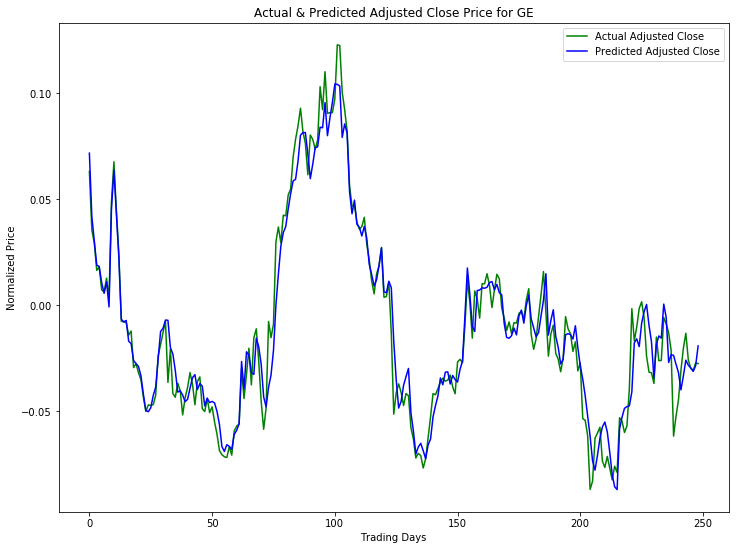

In [9]:
# Load datasets & Analysis
csv_file = './data/GE.csv'

# Get Adjusted Close price and split the data
adj_closes = load_adj_close(csv_file)
X_train_, y_train_, X_test_, y_test_ = load_data_split_train_test(adj_closes, seq_len, True)

# Build Model
model = Sequential()

model.add(LSTM(
    input_dim=input_dim,
    output_dim=output_dim,
    return_sequences=False))

model.add(Dense(
    output_dim=1))
model.add(Activation(activation))

start = time.time()
model.compile(loss=loss, optimizer=optimizer)
print 'compilation time : ', time.time() - start

#Train the model
model.fit(
    X_train_,
    y_train_,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_split=0.05)

testPredict = model.predict(X_test_, batch_size=batch_size)
score = model.evaluate(X_test_, y_test_, batch_size=batch_size, verbose=0)

GE_MSE = score
GE_RMSE = math.sqrt(score)
print 'Mean squared error (MSE)', GE_MSE
print 'Root Mean squared error (RMSE)', GE_RMSE

# Set up plot
plt.rcParams['figure.figsize'] = (12, 9)

fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test_,'g', label='Actual Adjusted Close')
plt.plot(testPredict, 'b', label='Predicted Adjusted Close')

# Set title
ax.set_title('Actual & Predicted Adjusted Close Price for GE')
ax.legend(loc='upper right')

plt.show()

### Microsoft

/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=30, return_sequences=False, input_shape=(None, 1))`
  
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


compilation time :  0.054211139679
Train on 2126 samples, validate on 112 samples
Epoch 1/1
2126/2126 [==============================] - 243s - loss: 6.2313e-04 - val_loss: 2.9584e-04
Mean squared error (MSE) 0.000104691520582
Root Mean squared error (RMSE) 0.0102318874398


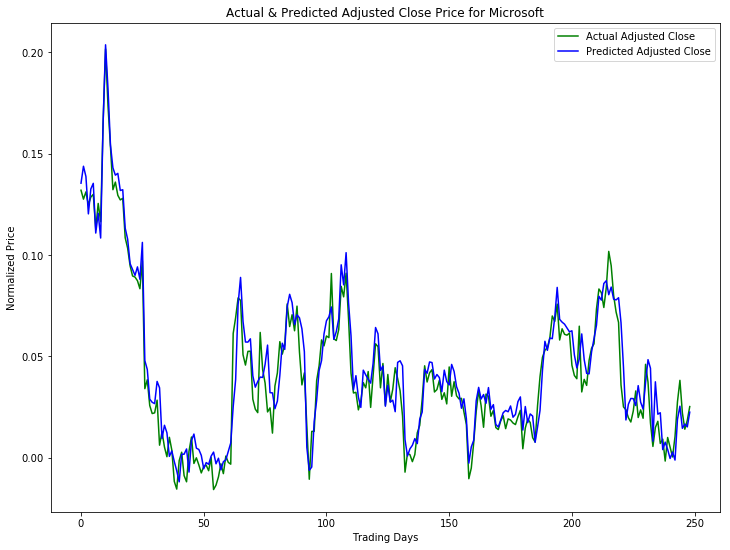

In [10]:
# Load datasets & Analysis
csv_file = './data/MSFT.csv'

# Get Adjusted Close price and split the data
adj_closes = load_adj_close(csv_file)
X_train_, y_train_, X_test_, y_test_ = load_data_split_train_test(adj_closes, seq_len, True)

# Build Model
model = Sequential()

model.add(LSTM(
    input_dim=input_dim,
    output_dim=output_dim,
    return_sequences=False))

model.add(Dense(
    output_dim=1))
model.add(Activation(activation))

start = time.time()
model.compile(loss=loss, optimizer=optimizer)
print 'compilation time : ', time.time() - start

#Train the model
model.fit(
    X_train_,
    y_train_,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_split=0.05)

testPredict = model.predict(X_test_, batch_size=batch_size)
score = model.evaluate(X_test_, y_test_, batch_size=batch_size, verbose=0)

MSFT_MSE = score
MSFT_RMSE = math.sqrt(score)
print 'Mean squared error (MSE)', MSFT_MSE
print 'Root Mean squared error (RMSE)', MSFT_RMSE

# Set up plot
plt.rcParams['figure.figsize'] = (12, 9)

fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test_,'g', label='Actual Adjusted Close')
plt.plot(testPredict, 'b', label='Predicted Adjusted Close')

# Set title
ax.set_title('Actual & Predicted Adjusted Close Price for Microsoft')
ax.legend(loc='upper right')

plt.show()

### S&P 500

/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=30, return_sequences=False, input_shape=(None, 1))`
  
/Users/yuichihagio/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`


compilation time :  0.31093788147
Train on 2126 samples, validate on 112 samples
Epoch 1/1
2126/2126 [==============================] - 226s - loss: 3.7717e-04 - val_loss: 2.0490e-04
Mean squared error (MSE) 6.13824635252e-05
Root Mean squared error (RMSE) 0.00783469613484


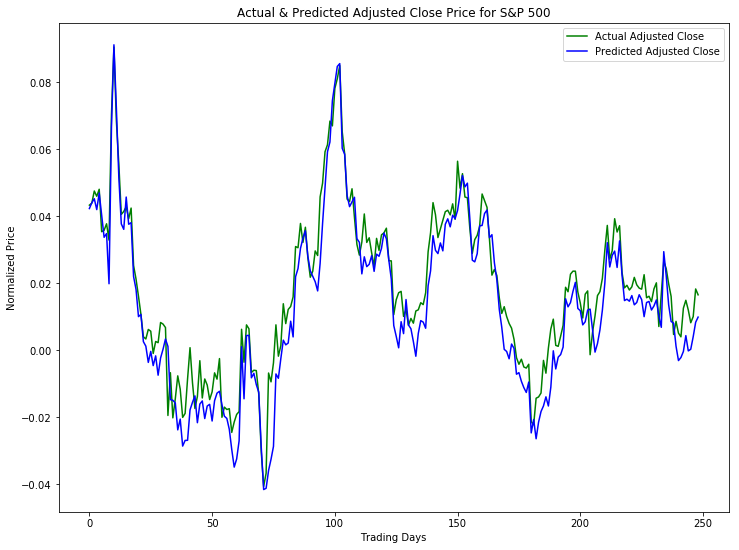

In [11]:
# Load datasets & Analysis
csv_file = './data/^GSPC.csv'

# Get Adjusted Close price and split the data
adj_closes = load_adj_close(csv_file)
X_train_, y_train_, X_test_, y_test_ = load_data_split_train_test(adj_closes, seq_len, True)

# Build Model
model = Sequential()

model.add(LSTM(
    input_dim=input_dim,
    output_dim=output_dim,
    return_sequences=False))

model.add(Dense(
    output_dim=1))
model.add(Activation(activation))

start = time.time()
model.compile(loss=loss, optimizer=optimizer)
print 'compilation time : ', time.time() - start

#Train the model
model.fit(
    X_train_,
    y_train_,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    validation_split=0.05)

testPredict = model.predict(X_test_, batch_size=batch_size)
score = model.evaluate(X_test_, y_test_, batch_size=batch_size, verbose=0)

GSPC_MSE = score
GSPC_RMSE = math.sqrt(score)
print 'Mean squared error (MSE)', GSPC_MSE
print 'Root Mean squared error (RMSE)', GSPC_RMSE

# Set up plot
plt.rcParams['figure.figsize'] = (12, 9)

fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Normalized Price')
plt.xlabel('Trading Days')

# Plot actual and predicted close values
plt.plot(y_test_,'g', label='Actual Adjusted Close')
plt.plot(testPredict, 'b', label='Predicted Adjusted Close')

# Set title
ax.set_title('Actual & Predicted Adjusted Close Price for S&P 500')
ax.legend(loc='upper right')

plt.show()

### Results

In [12]:
print 'Toyota (MSE): ', TM_MSE 
print 'Toyota (RMSE): ', TM_RMSE 
print 'Apple (MSE): ', APPL_MSE 
print 'Apple (RMSE): ', APPL_RMSE 
print 'GE (MSE): ', GE_MSE 
print 'GE (RMSE): ', GE_RMSE 
print 'Microsoft (MSE): ', MSFT_MSE 
print 'Microsoft (RMSE): ', MSFT_RMSE 
print 'S&P 500 (MSE): ', GSPC_MSE 
print 'S&P 500 (RMSE): ', GSPC_RMSE 

Toyota (MSE):  0.000143752868767
Toyota (RMSE):  0.0119896984435
Apple (MSE):  0.000206062711005
Apple (RMSE):  0.0143548845695
GE (MSE):  0.000102261837848
GE (RMSE):  0.010112459535
Microsoft (MSE):  0.000104691520582
Microsoft (RMSE):  0.0102318874398
S&P 500 (MSE):  6.13824635252e-05
S&P 500 (RMSE):  0.00783469613484
